![Texto alternativo](perros_gatos.png)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt



2025-04-27 17:58:08.915751: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 17:58:08.919006: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 17:58:08.927828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745776688.948346    4602 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745776688.952628    4602 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745776688.965109    4602 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Paso 1: Cargar CIFAR-10 y filtrar gatos (label 3) y perros (label 5)
(X_train_full, y_train_full), (X_test_full, y_test_full) = tf.keras.datasets.cifar10.load_data()

| Label | Clase                       |
|-------|-----------------------------|
| 0     | avión (airplane) ✈️         |
| 1     | automóvil (automobile) 🚗    |
| 2     | pájaro (bird) 🐦             |
| 3     | gato (cat) 🐱                |
| 4     | ciervo (deer) 🦌             |
| 5     | perro (dog) 🐶               |
| 6     | rana (frog) 🐸               |
| 7     | caballo (horse) 🐴           |
| 8     | barco (ship) 🚢              |
| 9     | camión (truck) 🚚            |


In [3]:

# Aplanamos las etiquetas para trabajar fácilmente
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()

In [5]:
# Filtramos solo gatos (3) y perros (5)
train_filter = np.where((y_train_full == 3) | (y_train_full == 5))
test_filter = np.where((y_test_full == 3) | (y_test_full == 5))

In [6]:
train_filter

(array([    9,    17,    21, ..., 49982, 49983, 49988]),)

In [8]:
type(test_filter)

tuple

In [9]:
X_train, y_train = X_train_full[train_filter], y_train_full[train_filter]
X_test, y_test = X_test_full[test_filter], y_test_full[test_filter]

In [10]:
X_train

array([[[[125, 125, 116],
         [110, 101,  91],
         [102,  90,  83],
         ...,
         [202, 207, 214],
         [200, 205, 212],
         [202, 208, 214]],

        [[142, 146, 142],
         [146, 144, 139],
         [176, 172, 170],
         ...,
         [195, 201, 205],
         [198, 205, 209],
         [204, 211, 215]],

        [[180, 185, 183],
         [143, 146, 146],
         [156, 157, 157],
         ...,
         [122, 111, 113],
         [139, 128, 131],
         [158, 147, 150]],

        ...,

        [[104,  82,  41],
         [101,  80,  39],
         [101,  81,  38],
         ...,
         [126, 103,  67],
         [126, 103,  69],
         [125, 101,  68]],

        [[104,  81,  40],
         [105,  84,  41],
         [109,  88,  43],
         ...,
         [138, 113,  78],
         [137, 113,  80],
         [137, 112,  81]],

        [[105,  83,  42],
         [108,  87,  45],
         [115,  94,  50],
         ...,
         [143, 117,  82],
        

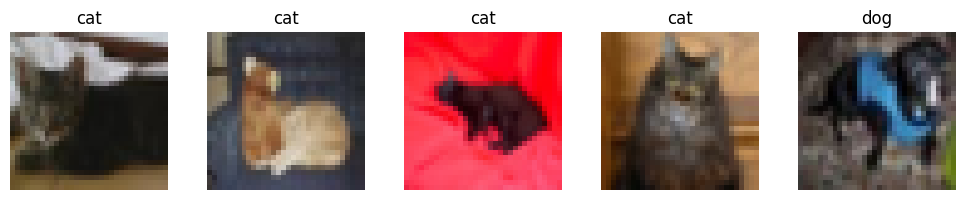

In [11]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
# Buscar índices de gatos (3) y perros (5)
indices = np.where((y_train == 3) | (y_train == 5))[0]

# Mostrar las primeras 5 imágenes de gatos/perros
plt.figure(figsize=(10, 2))
for i, idx in enumerate(indices[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[idx])
    label = class_names[y_train[idx]]
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Convertimos a etiquetas binarias: gato = 0, perro = 1
y_train = (y_train == 5).astype(np.uint8) # true en 1 (perro) , false en 0 (gato).
y_test = (y_test == 5).astype(np.uint8)

In [13]:
type(X_train)

numpy.ndarray

In [14]:
len(X_train)

10000

In [15]:
X_train[0].shape

(32, 32, 3)

In [16]:
y_train

array([0, 0, 0, ..., 0, 0, 1], dtype=uint8)

In [17]:
y_test

array([0, 0, 1, ..., 0, 0, 1], dtype=uint8)

In [18]:
# Normalizamos las imágenes [0,1]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [19]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (10000, 32, 32, 3), y_train shape: (10000,)


In [20]:
model = Sequential([

    # Capa 1: Convolucional
    Conv2D(
        filters=32,               # 🧩 Número de filtros
        kernel_size=(3, 3),       # 📏 Tamaño del filtro (kernel)
        activation='relu',       # ⚡ Función de activación
        input_shape=(32, 32, 3)   # 📷 Tamaño de la imagen de entrada (alto, ancho, canales)
    ),

    # Capa 2: MaxPooling
    MaxPooling2D(
        pool_size=(2, 2)          # 🌀 Tamaño de la ventana de pooling (reducción de tamaño)
    ),

    # Capa 3: Convolucional
    Conv2D(
        filters=64,               # 🧩 Más filtros para capturar más patrones complejos
        kernel_size=(3, 3),       # 📏 Mismo tamaño de kernel
        activation='relu'        # ⚡ Activación ReLU
    ),

    # Capa 4: MaxPooling
    MaxPooling2D(
        pool_size=(2, 2)          # 🌀 Mismo tamaño de pooling
    ),

    # Capa 5: Aplanar los mapas de activación
    Flatten(),                   # 🔁 Convierte la salida 2D a un vector 1D

    # Capa 6: Densa (oculta)
    Dense(
        units=64,                # 🔢 Número de neuronas
        activation='relu'        # ⚡ Activación ReLU
    ),

    # Capa 7: Densa (salida)
    Dense(
        units=1,                 # 🔘 Clasificación binaria (0 o 1)
        activation='sigmoid'     # ✅ Activación Sigmoide para salida entre 0 y 1
    )
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])

model.summary()

/home/vscode/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-14 23:58:07.319443: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,977 (652.25 KB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
len(X_train)

10000

In [22]:
len(X_test)

2000

In [23]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, y_test))

Epoch 1/20


2025-04-14 23:58:18.432379: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


  5/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - auc: 0.4536 - loss: 0.7428

2025-04-14 23:58:19.992514: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19663488 exceeds 10% of free system memory.
2025-04-14 23:58:19.993236: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19663488 exceeds 10% of free system memory.
2025-04-14 23:58:20.055104: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19663488 exceeds 10% of free system memory.
2025-04-14 23:58:20.055268: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19663488 exceeds 10% of free system memory.


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - auc: 0.5524 - loss: 0.6930 - val_auc: 0.6819 - val_loss: 0.6416
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - auc: 0.7024 - loss: 0.6262 - val_auc: 0.7595 - val_loss: 0.5984
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - auc: 0.7587 - loss: 0.5843 - val_auc: 0.7892 - val_loss: 0.5577
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - auc: 0.7977 - loss: 0.5452 - val_auc: 0.7911 - val_loss: 0.5560
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - auc: 0.8085 - loss: 0.5302 - val_auc: 0.8050 - val_loss: 0.5364
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - auc: 0.8261 - loss: 0.5114 - val_auc: 0.8096 - val_loss: 0.5337
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - auc: 0.8465 - loss: 0.4839 - val_auc: 0.8232 - val_loss: 0.5456
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - auc: 0.8668 - loss: 0.4553 - val_auc: 0.8261 - val_loss: 0.5212
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
AUC Score: 0.8318


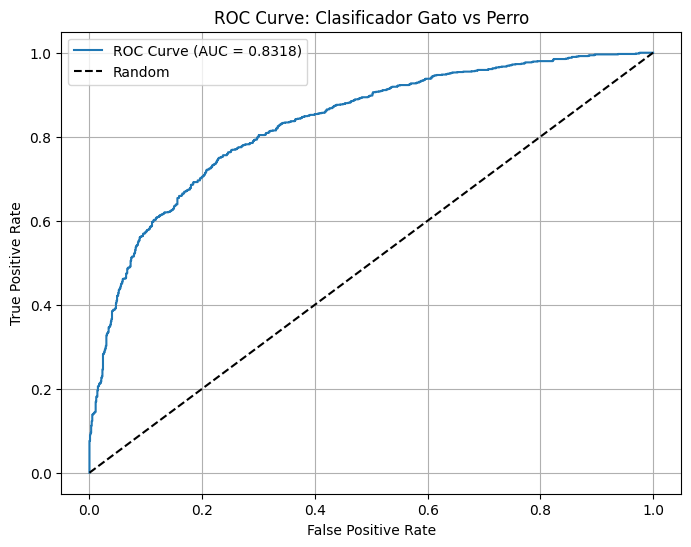

In [24]:
# Predicciones de probabilidad
y_proba = model.predict(X_test).flatten()

# Cálculo de la métrica AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC Score: {auc_score:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Clasificador Gato vs Perro')
plt.legend()
plt.grid(True)
plt.show()